## Problem Statement


FashionKart allows consumers to buy latest products from e-commerce platforms. Customers can leave reviews of products and experience to help other users make their purchase choices.

Given the dataset of product reviews and recommendation status, build a text classification model that can correctly identify the users who will recommend the product in the future. Also provide key topics/themes emerging from the customer reviews along with visualisation charts.

**Review:** Customer review for the product

**Recommendation:** Customer's recommendation for the product

## Table of Content

1. **[Import Libraries](#lib)**
2. **[Load the Data](#data)**
3. **[Data Exploration](#eda)**
4. **[Data Preperation](#prep)**
5. **[Data Split](#split)**
6. **[Machine Learning Modeling](#model)**
    - 6.1 - **[Count vectorizer](#cv)**
    - 6.2 - **[TF-IDF](#tfidf)**
7. **[Topic Modelling ](#topic)**
    - 7.1 - **[Topic Visualization](#vis)**

<a id="lib"></a>
### Step 1 : Load required libraries

In [46]:
pip install umap

In [47]:
pip install pyLDAvis

In [48]:
#import the libraries
import numpy as np
import pandas as pd
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import umap
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from nltk import sent_tokenize, word_tokenize
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<a id="data"></a>
### Step 2 : Load the input data

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
file_path = '/content/drive/My Drive/Colab Notebooks/Text classification/dataset.csv'

In [51]:
#read the input data
input_data = pd.read_csv(file_path)
#scan the dataframe
input_data.head()

,Review,Recommend
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [52]:
#convert the object datatype type to string
input_data.info()
input_data['Review']=input_data['Review'].astype('str')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     22641 non-null  object
 1   Recommend  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


In [53]:
#check the size of the dataframe
input_data.shape

(23486, 2)

In [54]:
#check the target class distribution in the dataset
input_data['Recommend'].value_counts()

,count
Recommend,
1,19314
0,4172


As we can see there are around 23K+ reviews in the dataset. Each review has a corresponding recommendation value and there are more recommended products compared to non-recommended

<a id="eda"></a>
### Step 3 : Explore the data

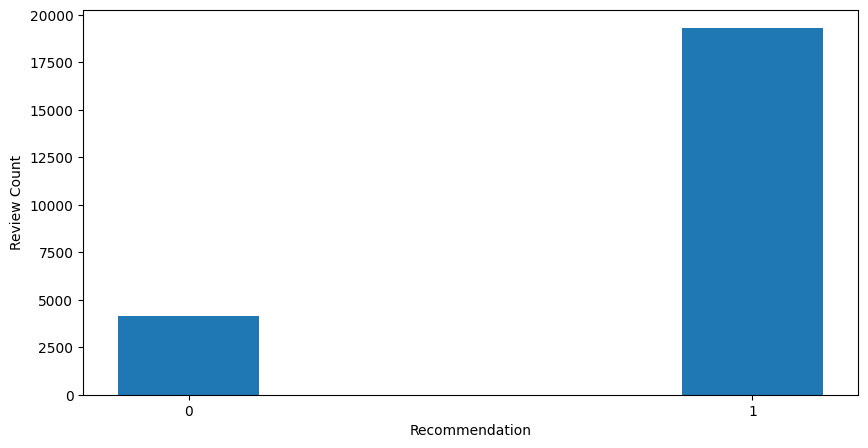

In [55]:
#check for the target class counts
label_dist = input_data['Recommend'].value_counts().to_dict()
fig = plt.figure(figsize = (10, 5))
ax = plt.bar(label_dist.keys(), label_dist.values(), width=0.25)
plt.xticks([0,1])
plt.xlabel("Recommendation")
plt.ylabel("Review Count")
plt.show()

In [56]:
#check for any empty rows
print(input_data.isnull().sum())

Review       0
Recommend    0
dtype: int64


In [57]:
#check for any duplicate reviews
len(input_data['Review'])-len(input_data['Review'].drop_duplicates())


851

As we can observe there are 851 reviews which seem to be duplicate values. We will drop these from the dataframe.

In [58]:
#drop the repeated reviews
input_data=input_data.drop_duplicates(subset='Review', keep="last")
input_data.shape

(22635, 2)

We can now check the size of each review to establish if there is any relation between the recommendation and length of the reviews

In [59]:
#check for the length of reviews
input_data['length']=input_data['Review'].apply(lambda x: len(x.split(' ')))

In [60]:
#validate the newly added column in the dataframe
input_data.sample(10)

,Review,Recommend,length
16243,"I just received the top today, and will send b...",1,87
21894,"Love this top, super soft and drapes great, ev...",1,31
13048,"I loved how the skirt looked on the model, but...",0,80
23011,I love these little socks ? and the dots spark...,1,32
1981,"This top! it is so simple, but so great at the...",1,96
17163,I cannot say how much i love this dress. i pur...,1,97
3240,I stumbled upon this vest in my local store an...,1,60
17386,I went back and forth about buying this jumpsu...,1,59
20182,This is a cute top but i wore it for around 5 ...,0,70
7978,I love boiled wool and have gotten a few items...,0,93


In [61]:
#avg. length for recommended and non recommended review
print(round(input_data[input_data['Recommend']== 1 ]['length'].mean()))
print(round(input_data[input_data['Recommend']== 0]['length'].mean()))

60
62


Seems like there isn't much of a difference between size of the customer review in the dataset

<a id="prep"></a>
### Step 4 : Data Preperation

Since the reviews are raw texts and contains multiple symbols, punctuations , hastags which might not be very useful for the modeling .
We will use a helper function to clean the text and prepare it for modeling purpose.

In [62]:
# helper function to remove stopwords
input_data["Review_new"]=input_data["Review"].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

In [63]:
#helper function for review cleaning
def text_clean(review):
    #lowercase the review
    review=review.lower()
    #remove punctuation
    review = re.sub('[()!?]', ' ', review)
    review = re.sub('\[.*?\]',' ', review)
    #remove non alphanumeric occurences
    review = re.sub("[^a-z0-9]"," ", review)
    #remove the @mention
    review = re.sub("@[A-Za-z0-9_]+","", review)
    #remove the hastags
    review = re.sub("#[A-Za-z0-9_]+","", review)
    #remove any links
    review = re.sub(r"http\S+", "", review)
    review = re.sub(r"www.\S+", "", review)
    return review

In [64]:
#apply the function on the review column
input_data['clean_review'] = input_data['Review_new'].apply(text_clean)

In [65]:
#validate if the reviews are clean
input_data[['Review','clean_review']].sample(10)

,Review,clean_review
3374,I love this blouse. it is perfect for a curvy ...,i love blouse perfect curvy figure think run...
22720,I wasn't sure how clingy this dress might be o...,i sure clingy dress might would look curvy b...
18572,I tried these on as i needed bottoms to try on...,i tried needed bottoms try tops and wearing d...
14286,"I love this swimsuit - the color, the pattern ...",i love swimsuit color pattern coverage mat...
13074,I had to return this because the lining is sup...,i return lining super short uneven shorter ba...
2800,"Love this shirt, can dress up or more casual. ...",love shirt dress casual wish would purchased...
10068,I'm 5 feet 120 and hourglass figure. i literal...,i m 5 feet 120 hourglass figure literally bur...
13754,This top had so much potential! i bought the s...,this top much potential bought striped colorw...
17695,"This is such a cute dress, and i don't know wh...",this cute dress know know one reviewed yet d...
5787,"The smallest size, xs, was big on me, i was ov...",the smallest size xs big me overwhelmed swe...


We can now observe that each review looks much cleaner and neat post the data cleansing prcoess

In [66]:
# alculate updated length after removing the stopwords and cleaning review
input_data['new_length']=input_data['clean_review'].apply(lambda x: len(x.split(" ")))

In [67]:
#avg. length of the review for recommended and non-recommended labels
print(round(input_data[input_data['Recommend']== 1]['new_length'].mean()))
print(round(input_data[input_data['Recommend']== 0]['new_length'].mean()))


41
41


Post the data cleaning, the avg. length of the review becomes the same

<a id="split"></a>
### Step 5 : Data split

Now we split the 23K+ data into training and test dataset. One thing to note is to split the data based on target class to maintain the class balance

In [68]:
#Sentiment Classifier
#split the data into training and test set with balanced split based on target class
X_train, X_test, y_train, y_test = train_test_split(input_data["clean_review"],
                                                    input_data["Recommend"],test_size=0.3,
                                                    stratify=input_data['Recommend'])

In [69]:
#check the shape of train and test data
print(X_train.shape[0],X_test.shape[0])

15844 6791


In [70]:
#check the class balance in train data
print(y_train.value_counts())

Recommend
1    12974
0     2870
Name: count, dtype: int64


In [71]:
#check the target class balance in test data
print(y_test.value_counts())

Recommend
1    5561
0    1230
Name: count, dtype: int64


<a id="model"></a>
### Step 6  : ML Modeling and Performance evaluation

After splitting the data , we move on to the modelling part. Given we are doing text classification, we will convert the text data using two approaches :
1. Count Vectoriser
2. TF-IDF


<a id="cv"></a>
#### Using Count vectorizer

In [72]:
#Build a list of models to be trained and tested
modelclasses = [
    ["Logistic Regression", LogisticRegression],
    ["MNB", MultinomialNB],
    ["Random Forest", RandomForestClassifier]]

In [73]:
#Use the count vectoriser to convert the text data to numerical form
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#create an empty dataframe to log performance of the model based on score and auc
#results = pd.DataFrame(columns = ['modelname','score','auc'])

#for modelname, Model in modelclasses:
#    model = Model()
#    model.fit(X_train_vec, y_train)
#    score = np.round(model.score(X_test_vec, y_test),2)
#    auc=np.round(roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1]),2)
#    results = results.append({'modelname' : modelname, 'score' : score,'auc':auc},
#        ignore_index = True)


results = []  # Initialize results as a list

for modelname, Model in modelclasses:
    model = Model()
    model.fit(X_train_vec, y_train)
    score = np.round(model.score(X_test_vec, y_test), 2)
    auc = np.round(roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1]), 2)

    # Append a dictionary to the results list
    results.append({'modelname': modelname, 'score': score, 'auc': auc})

# Create a DataFrame from the list of dictionaries
results = pd.DataFrame(results)


In [74]:
# Model performance
results

,modelname,score,auc
0,Logistic Regression,0.89,0.91
1,MNB,0.89,0.92
2,Random Forest,0.86,0.91


As we can observe , the Multinomial Naive Baysian performs the best out of all the models using count vectoriser

<a id="tfidf"></a>
#### Using TF-IDF

In [75]:
# Use the tf-idf vectoriser to convert the text data to numerical form
vectorizertfidf = TfidfVectorizer(token_pattern=r'\b\w+\b')
X_train_vec = vectorizertfidf.fit_transform(X_train)
X_test_vec = vectorizertfidf.transform(X_test)
results_tf = []

for modelname, Model in modelclasses:
    model = Model()
    model.fit(X_train_vec, y_train)
    score = np.round(model.score(X_test_vec, y_test), 2)
    auc = np.round(roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1]), 2)

    # Append a dictionary to the results_tf list
    results_tf.append({'modelname': modelname, 'score': score, 'auc': auc})

# Create a DataFrame from the list of dictionaries
results_tf = pd.DataFrame(results_tf)

In [76]:
#model comparison
results_tf

,modelname,score,auc
0,Logistic Regression,0.89,0.93
1,MNB,0.82,0.91
2,Random Forest,0.85,0.91


Using the tf-idf vectoriser, we observe Logistic Regression outperforming the other models in terms of accuracy and auc.

<a id="topic"></a>
## Step 7 : Topic Modeling

In [77]:
#add additonal data clearning
def topic_clean(review):
        #remove numeric & special characters occurences
        review = re.sub('[^a-zA-Z]', ' ', review)
        review = re.sub(r's+', ' ', review)
        return review

In [78]:
#apply the function on the review column
input_data['clean_review'] = input_data['clean_review'].apply(topic_clean)

In [79]:
# Extract every unique term from the reviews
review_terms = pd.Series(input_data['clean_review']).apply(lambda x: x.split())

In [80]:
# Create the disctioanry consisting index and unique term
dictionary = corpora.Dictionary(review_terms)

In [81]:
# Preapre the DTM(Document Term Matrix) from the term dictionary
doc_term_matrix = [dictionary.doc2bow(rev) for rev in review_terms]

In [82]:
# Build the LDA model for topic extraction
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=10,
                chunksize=500,
                passes=10)


In [83]:
#print the top 10 topics
lda_model.print_topics()


[(0,
  '0.042*"i" + 0.037*"t" + 0.036*"love" + 0.033*"it" + 0.020*"wear" + 0.016*"compliment" + 0.016*"one" + 0.015*"wore" + 0.015*"purcha" + 0.014*"ab"'),
 (1,
  '0.039*"jean" + 0.031*"pant" + 0.031*"e" + 0.023*"great" + 0.023*"i" + 0.021*"fit" + 0.020*"love" + 0.017*"the" + 0.017*"pair" + 0.014*"hort"'),
 (2,
  '0.050*"color" + 0.026*"top" + 0.023*"hirt" + 0.023*"love" + 0.023*"look" + 0.022*"kirt" + 0.021*"great" + 0.019*"blue" + 0.019*"fit" + 0.016*"oft"'),
 (3,
  '0.041*"on" + 0.033*"tore" + 0.024*"i" + 0.024*"tried" + 0.022*"online" + 0.020*"per" + 0.016*"t" + 0.015*"aw" + 0.015*"kirt" + 0.015*"try"'),
 (4,
  '0.039*"t" + 0.023*"like" + 0.022*"top" + 0.021*"look" + 0.020*"i" + 0.019*"o" + 0.018*"wai" + 0.015*"fabric" + 0.014*"al" + 0.014*"would"'),
 (5,
  '0.139*"wa" + 0.081*"di" + 0.057*"hed" + 0.051*"h" + 0.050*"appointed" + 0.025*"dry" + 0.020*"ba" + 0.018*"ic" + 0.018*"arrived" + 0.016*"hand"'),
 (6,
  '0.350*"dre" + 0.043*"ea" + 0.039*"y" + 0.025*"thi" + 0.019*"perfect" + 0.

<a id="vis"></a>
#### Topic Visualization

In [84]:
# Visualize the topics
pyLDAvis.enable_notebook()
# feed the LDA model into the pyLDAvis instance
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.116450 -0.108800       1        1  19.479873
4     -0.122327 -0.079671       2        1  18.571889
9     -0.082150 -0.122433       3        1  11.859055
2     -0.074538  0.091186       4        1   9.324560
1     -0.078174  0.079125       5        1   8.873856
8     -0.044361  0.144300       6        1   8.706790
3     -0.039714 -0.205552       7        1   8.653269
0     -0.067268  0.037529       8        1   8.128009
6      0.149705  0.297398       9        1   4.786105
5      0.475277 -0.133081      10        1   1.616593, topic_info=       Term          Freq         Total Category  logprob  loglift
9       dre  13337.000000  13337.000000  Default  30.0000  30.0000
51      ize   9769.000000   9769.000000  Default  29.0000  29.0000
55     mall   4881.000000   4881.000000  Default  28.0000  28.0000
558      wa   1711.000000   1711.000000  Default  27.0000  27.0000
478  weater   2869.000000   2869.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
511      ic    228.126206    521.303061  Topic10  -3.9900   3.2984
134      ba    250.823820    633.645007  Topic10  -3.8952   3.1981
368    cold    108.727182    234.907285  Topic10  -4.7311   3.3545
757      in    102.949633   1426.296522  Topic10  -4.7857   1.4963
702    hang     78.371451    511.655174  Topic10  -5.0585   2.2487

[638 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         8  0.998738           ab
2891      5  0.992426  accommodate
1357      1  0.995775          ack
609       2  0.997504         acro
999       7  0.996757           ad
...     ...       ...          ...
199       1  0.994020           xx
199       7  0.003780           xx
765       9  0.999126            y
73        7  0.996436          zip
74        7  0.996635       zipper

[1098 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 10, 3, 2, 9, 4, 1, 7, 6])